In [1]:
#Installing packages and loading them into the enviroment
install.packages("MASS")
library("MASS")
install.packages("missMDA")
library("missMDA")
install.packages("tidyverse")
library("tidyverse")
install.packages("caret")
library("caret")
install.packages("mice")
library("mice")

Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'MASS' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpQ5iNhq\downloaded_packages


Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'missMDA' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpQ5iNhq\downloaded_packages


Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpQ5iNhq\downloaded_packages


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0            v purrr   0.3.3       
v tibble  2.99.99.9014     v dplyr   0.8.99.9000 
v tidyr   1.0.2            v stringr 1.4.0       
v readr   1.3.1            v forcats 0.4.0       

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks MASS::select()

Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'caret' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpQ5iNhq\downloaded_packages


Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)




  There is a binary version available but the source version is later:
     binary source needs_compilation
mice  3.9.0 3.10.0              TRUE



installing the source package 'mice'


Warning message in install.packages("mice"):
"installation of package 'mice' had non-zero exit status"

Attaching package: 'mice'


The following object is masked from 'package:tidyr':

    complete


The following objects are masked from 'package:base':

    cbind, rbind




In [11]:
#Loading all needed files,dropping first two coloumns, which are not needed for analysis (ID, species)
ionomics <- read.csv('spec_shoot_xyz_concat.csv', colClasses =c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))
hybrids <- read.csv('spec_shoot_xyz_concat_unk_only.csv', colClasses = c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))

#Imputation via missMDA
imputeIonomics <- imputePCA(ionomics, method = "Regularized")

In [12]:
#Imputation via Mice
# TODO add in fit graphics and missing data quantification
temp <- mice(ionomics, m = 1, maxit = 5, method = "norm.boot", seed = 567)
ionomicsComplete <- complete(temp,1)


 iter imp variable
  1   1  S34_X
  2   1  S34_X
  3   1  S34_X
  4   1  S34_X
  5   1  S34_X


In [6]:
#data imputed with missMDA regularized method
mean.impute <- 0 #Start our average with 0
for (x in 1:10000){ # run 10000 permutations
    set.seed(x) #cycle through many random generator seeds
    training.samples.impute <- imputeIonomics$completeObs[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ] #generate training set
    test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ] #generate test set
    train.data.impute <- unlist(train.data.impute) #typecast from matrix into dataframe
    test.data.impute <- unlist(test.data.impute)
    train.data.impute <- as.data.frame(train.data.impute)
    test.data.impute <- as.data.frame(test.data.impute)
    model.impute <- lda(spec_as_int~., data = train.data.impute) #generate the LDA model
    predictions.impute <- model.impute %>% predict(test.data.impute) #predict the species of individuals in our test set based off of this model
    mean.impute = mean.impute + mean(predictions.impute$class==test.data.impute$spec_as_int) #measure how often this prediction is correct, then add it to a running total
}
mean.impute = mean.impute/9999 #divide running total by number of runs to find our average
mean.impute #print this average to the screen

#data imputed with mice, norm.boot method
mean.mice = 0 #Start our average with 0
for (x in 1:10000){ #run 10000 permutations
    set.seed(x)  #cycle through many random generator seeds
    training.samples.mice <- ionomicsComplete[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.mice <- ionomicsComplete[training.samples.mice, ] #generate training set
    test.data.mice <- ionomicsComplete[-training.samples.mice, ] #generate test set
    model.mice <- lda(spec_as_int~., data = train.data.mice) #generate the LDA model
    predictions.mice <- model.mice %>% predict(test.data.mice) #predict the species of individuals in our test set based off of this model
    mean.mice = mean.mice + mean(predictions.mice$class==test.data.mice$spec_as_int) #measure how often this prediction is correct, then add it to a running total
}
mean.mice = mean.mice/9999 #divide running total by number of runs to find our average
mean.mice #print this average to the screen

[1] 0.8103421

[1] 0.8103227

|species|spec_as_int|
|---|---|
|acerifolia_x|1|
|cinerea_x|3|
|labrusca_x|4|
|riparia_x|6|
|rupestris_x|7|
|vulpina_x|8|

In [15]:
df.impute <- as.data.frame(unlist(imputeIonomics$completeObs))
lda.impute <- lda(spec_as_int~., data = df.impute)
pred.impute <- predict(lda.impute)
pred.hybrids <- lda.impute %>% predict(hybrids)
viz.impute <- data.frame(spec = df[1], lda = pred$x)
viz.hybrids <- data.frame()
viz$spec = as.factor(viz$spec)
ggplot(viz) +geom_point(aes(lda.LD1, lda.LD2, color = spec)) 

ERROR: Error in pred.hybrids + aes(lda.LD1, lda.LD2, color = spec): non-numeric argument to binary operator


In [46]:
# Split the data into training (80%) and test set (20%)
#data set imputed via mice
set.seed(321)
training.samples <- ionomicsComplete[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data <- ionomicsComplete[training.samples, ]
test.data <- ionomicsComplete[-training.samples, ]

In [47]:
#unimputed
training.samples.raw <- ionomics[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data.raw <- ionomics[training.samples.raw, ]
test.data.raw <- ionomics[-training.samples.raw, ]

In [48]:
#data set imputed via missMDA
training.samples.impute <- imputeIonomics$completeObs[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ]
test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ]
#typecasting from matrix to dataframe
train.data.impute <- unlist(train.data.impute)
test.data.impute <- unlist(test.data.impute)
train.data.impute <- as.data.frame(train.data.impute)
test.data.impute <- as.data.frame(test.data.impute)

In [49]:
# Fit the model
#data set imputed with mice
model <- lda(spec_as_int~., data = train.data)
# Make predictions
predictions <- model %>% predict(test.data)
# Model accuracy
mean(predictions$class==test.data$spec_as_int)
model

[1] 0.7777778

Call:
lda(spec_as_int ~ ., data = train.data)

Prior probabilities of groups:
         1          3          4          6          7          8 
0.07284768 0.12582781 0.21854305 0.38410596 0.13907285 0.05960265 

Group means:
        B11_X        B11_Y      B11_Z      Na23_X     Na23_Y     Na23_Z
1 -0.17256669 -0.434977244 -0.2057491 -0.01825718 -0.5650618  0.4330715
3  0.18785641 -0.007023145 -0.4910085  1.60481929 -0.2041944 -0.4174722
4  0.28066609 -0.342465394 -0.3678176  1.14568417 -0.4513832 -0.2480192
6  0.58215414 -0.201072620  0.1937366  0.49469234 -0.6536985 -0.1537164
7  0.56667142 -0.134151123  0.1049405  0.38715176 -0.7524820 -0.4004899
8 -0.05245937 -0.134290825 -0.1931108  0.27482190 -0.6270245 -0.6154550
      Mg26_X      Mg26_Y    Mg26_Z      Al27_X     Al27_Y      Al27_Z
1 -0.8339243 -0.72296622 0.9449621  0.17237727 -0.8718441  0.85058622
3 -0.4953015 -0.09632494 0.9584399  0.26864505 -0.1584270  0.69430268
4 -0.5393209 -0.05078842 2.2636365  0.18135360 -0.6474727  0

In [50]:
#unimputed
model.raw <- lda(spec_as_int~., data = train.data.raw)
# Make predictions
predictions.raw <- model.raw %>% predict(test.data.raw)
# Model accuracy
mean(predictions.raw$class==test.data.raw$spec_as_int)
model.raw

[1] 0.8611111

Call:
lda(spec_as_int ~ ., data = train.data.raw)

Prior probabilities of groups:
         1          3          4          6          7          8 
0.07333333 0.15333333 0.20666667 0.39333333 0.12666667 0.04666667 

Group means:
        B11_X      B11_Y       B11_Z      Na23_X     Na23_Y     Na23_Z
1 -0.35755405 -0.3974882 -0.11151074 -0.03704999 -0.5614987  0.4058184
3  0.03190019 -0.0533636 -0.48875073  1.65945731 -0.1437872 -0.3964704
4  0.33607211 -0.4477563 -0.39559694  1.10080521 -0.4196059 -0.2659087
6  0.71714293 -0.1656793  0.22261089  0.51647291 -0.6602039 -0.1276913
7  0.55194605 -0.1929454  0.06497191  0.39890424 -0.7533578 -0.5036272
8 -0.05942551 -0.1152416 -0.34412059  0.34466578 -0.6483299 -0.7092925
      Mg26_X      Mg26_Y    Mg26_Z      Al27_X     Al27_Y      Al27_Z
1 -0.8565633 -0.79446389 0.9623575  0.19377486 -0.8764278  0.80937946
3 -0.5011207 -0.13964830 0.9447996  0.32050309 -0.1957806  0.67891867
4 -0.5426944 -0.06856277 2.1782790  0.16933440 -0.6892212  0.88

In [51]:
#data set imputed with missMDA
model.impute <- lda(spec_as_int~., data = train.data.impute)
# Make predictions
predictions.impute <- model.impute %>% predict(test.data.impute)
# Model accuracy
mean(predictions.impute$class == test.data.impute$spec_as_int)
model.impute
#TODO format data generated by model

[1] 0.8611111

Call:
lda(spec_as_int ~ ., data = train.data.impute)

Prior probabilities of groups:
         1          3          4          6          7          8 
0.05960265 0.14569536 0.21854305 0.37748344 0.13907285 0.05960265 

Group means:
        B11_X       B11_Y       B11_Z      Na23_X     Na23_Y     Na23_Z
1 -0.02181770 -0.44603230 -0.09190368 -0.05652589 -0.5610650  0.2942975
3 -0.13979622 -0.04254526 -0.43912495  1.44709102 -0.1091544 -0.4421390
4  0.30745485 -0.35215308 -0.35946639  1.05940078 -0.5334268 -0.2891038
6  0.70094513 -0.20318350  0.18033167  0.53818464 -0.6578769 -0.1920046
7  0.41873705 -0.13265537  0.18797534  0.40799455 -0.7214147 -0.3993235
8 -0.05245937 -0.13429082 -0.19311082  0.27482190 -0.6270245 -0.6154550
      Mg26_X       Mg26_Y    Mg26_Z      Al27_X     Al27_Y      Al27_Z
1 -0.8370477 -0.757260908 0.8298558  0.31965149 -0.8518445  0.86615338
3 -0.5113808 -0.090460764 1.0396173  0.18341301  0.1777591  0.55223149
4 -0.5560020 -0.004501815 2.2797343  0.25792109 -0

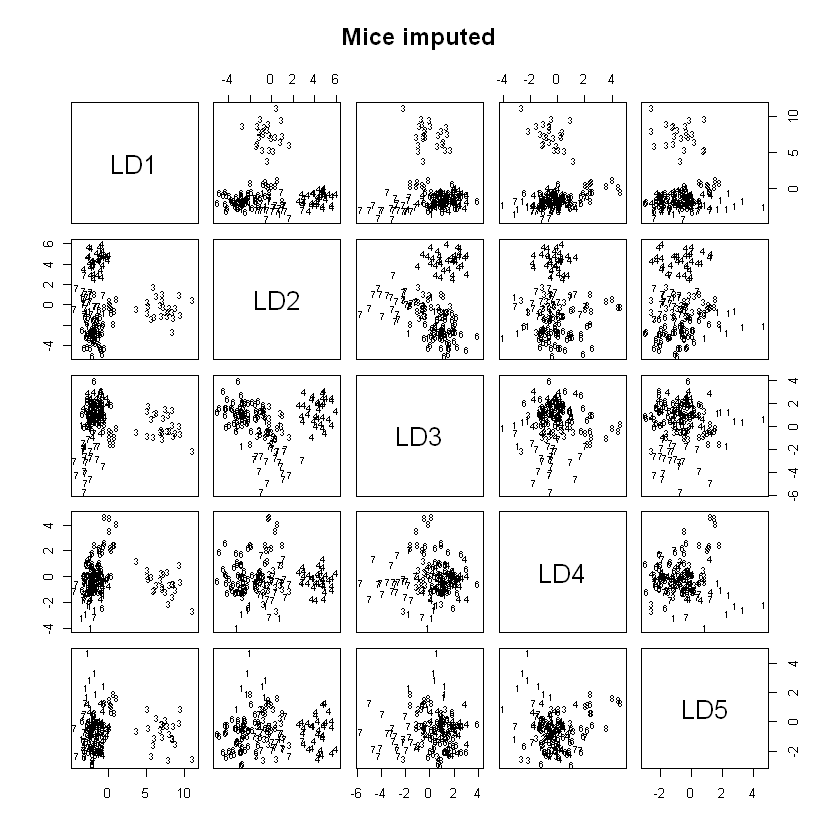

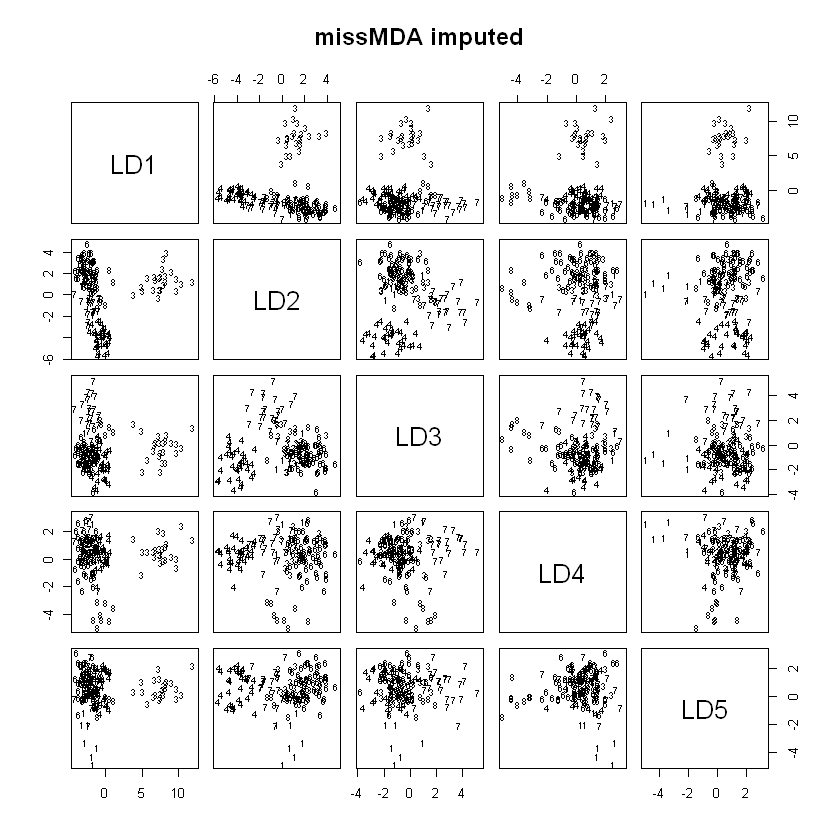

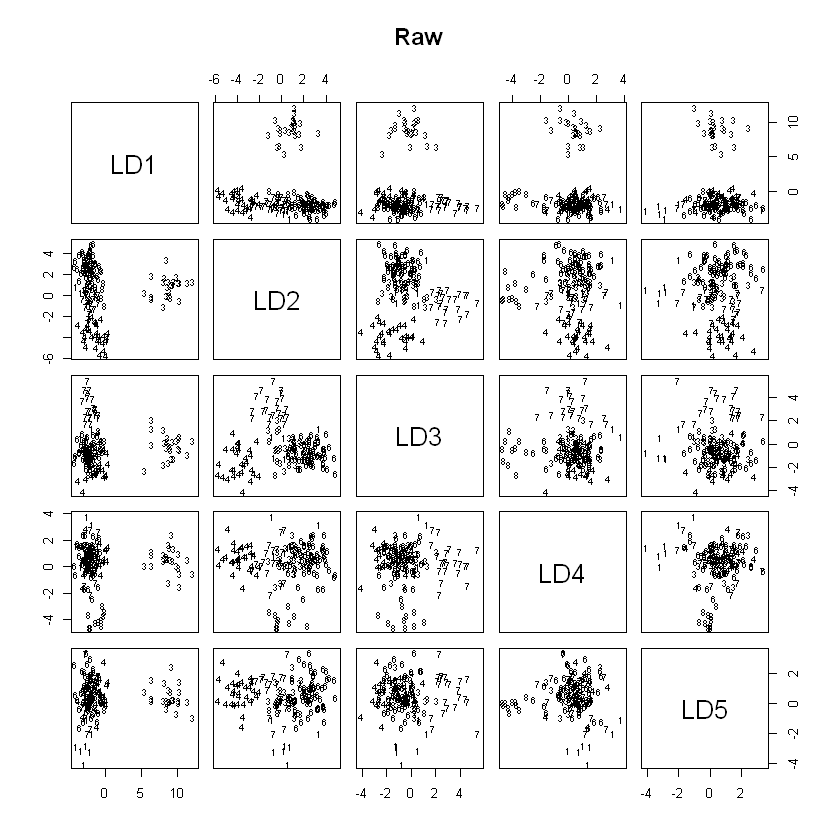

In [44]:
plot(model,main = "Mice imputed")
plot(model.impute, main = "missMDA imputed")
plot(model.raw, main = "Raw")
#TODO a better way to do this 

In [26]:
#mice imputed data
# Predicted classes
head(predictions$class, 6)
# Predicted probabilities of class memebership.
head(predictions$posterior, 6) 
# Linear discriminants
head(predictions$x, 3)

[1] 1 7 6 3 3 1
Levels: 1 3 4 6 7 8

,1,3,4,6,7,8
2,9.510620e-01,6.800732e-21,4.715715e-02,5.296300e-04,9.575659e-04,2.936088e-04
4,1.849138e-01,1.885129e-28,1.778946e-06,3.792845e-03,8.112825e-01,9.060687e-06
5,5.956748e-08,6.510739e-15,1.101954e-04,9.996270e-01,2.017565e-07,2.625663e-04
19,8.250344e-08,9.844077e-01,4.881888e-07,1.140327e-06,1.187008e-02,3.720514e-03
24,1.556535e-14,1.000000e+00,4.134959e-16,1.710240e-10,1.835663e-16,1.384097e-09
32,9.988395e-01,3.277622e-10,6.496871e-06,2.615485e-04,8.897660e-04,2.689362e-06


,LD1,LD2,LD3,LD4,LD5
2,-2.0291750,1.52042647,0.4945414,-0.5313014,2.980374
4,-3.9535509,-0.01703588,-1.3954866,-0.1406826,1.786150
5,-0.3176964,-0.26913114,2.5832177,1.6123440,-1.710545


In [27]:
#missMDA imputed data
# Predicted classes
head(predictions.impute$class, 6)
# Predicted probabilities of class memebership.
head(predictions.impute$posterior, 6) 
# Linear discriminants
head(predictions.impute$x, 3)

[1] 6 1 4 1 8 6
Levels: 1 3 4 6 7 8

,1,3,4,6,7,8
1,4.097888e-01,1.093519e-25,3.806113e-14,5.901514e-01,5.985094e-05,3.305205e-15
2,9.868757e-01,3.812593e-17,1.306281e-02,1.172018e-05,4.460974e-05,5.114547e-06
3,1.332710e-03,2.671691e-28,5.614838e-01,3.913913e-04,4.367921e-01,1.309601e-14
4,8.097344e-01,2.241194e-26,1.786893e-05,1.629680e-02,1.736085e-01,3.424617e-04
5,1.347413e-16,2.280297e-42,1.335947e-24,1.577954e-07,4.341543e-18,9.999998e-01
6,2.715585e-03,4.045438e-20,1.059284e-08,9.972844e-01,4.552000e-11,8.181852e-09


,LD1,LD2,LD3,LD4,LD5
1,-2.60511778,3.185983,0.7478028,3.7758420,-1.98387270
2,-0.04486002,-1.662486,-0.7644171,0.1136833,-3.72543575
3,-3.00354731,-2.738298,-0.1883810,3.8175375,0.09592768


In [28]:
#raw data
# Predicted classes
head(predictions.raw$class, 6)
# Predicted probabilities of class memebership.
head(predictions.raw$posterior, 6) 
# Linear discriminants
head(predictions.raw$x, 3)

[1] 1 1 1 1 1 3
Levels: 1 3 4 6 7 8

,1,3,4,6,7,8
7,7.934620e-01,8.414066e-20,8.943233e-11,2.065360e-01,6.645948e-07,1.335454e-06
8,9.998605e-01,7.928689e-27,9.381378e-16,7.270842e-05,6.676542e-05,1.457104e-11
10,9.999579e-01,4.418107e-23,7.553070e-14,4.209776e-05,1.376837e-08,1.901134e-10
11,9.933325e-01,1.919537e-15,2.131432e-07,6.648448e-03,7.851929e-07,1.806343e-05
12,9.999989e-01,8.449512e-28,5.535172e-15,1.088244e-06,2.778731e-10,3.876840e-11
23,3.708156e-41,1.000000e+00,8.927710e-37,5.551521e-37,2.878578e-37,1.326607e-31


,LD1,LD2,LD3,LD4,LD5
7,-1.362120,-2.164457,0.8993184,-0.890726,2.464698
8,-2.654154,-2.610537,-2.0255361,-2.757797,2.888569
10,-1.532139,-2.032895,0.0288177,-2.395961,3.905759


In [33]:
#raw data
table.raw <- table(Predicted=predictions.raw$class, Species=test.data.raw$spec_as_int)
confusionMatrix(table.raw)

Confusion Matrix and Statistics

         Species
Predicted  1  3  4  6  7  8
        1  5  0  0  0  0  0
        3  0  4  0  0  0  0
        4  0  0 11  0  0  0
        6  0  0  0 11  0  0
        7  0  0  0  0  3  0
        8  0  0  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.9722          
                 95% CI : (0.8547, 0.9993)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 4.864e-16       
                                          
                  Kappa : 0.9637          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 3 Class: 4 Class: 6 Class: 7 Class: 8
Sensitivity            1.0000   1.0000   1.0000   0.9167  1.00000  1.00000
Specificity            1.0000   1.0000   1.0000   1.0000  1.00000  0.97143
Pos Pred Value         1.0000   1.0000   1.0000   1.0000  1.00000  0.50000
Neg Pred Value         1

In [73]:
#missMDA data
table.impute <- table(Predicted=predictions.impute$class, Species=test.data.impute$spec_as_int)
con <- confusionMatrix(table.impute)
names(con)
names(con$overall)

[1] "positive" "table"    "overall"  "byClass"  "mode"     "dots"

[1] "Accuracy"       "Kappa"          "AccuracyLower"  "AccuracyUpper" 
[5] "AccuracyNull"   "AccuracyPValue" "McnemarPValue"

In [35]:
#mice data
table <- table(Predicted=predictions$class, Species=test.data$spec_as_int)
confusionMatrix(table)

Confusion Matrix and Statistics

         Species
Predicted  1  3  4  6  7  8
        1  1  1  0  0  0  0
        3  0  3  0  0  0  0
        4  0  0  6  0  0  0
        6  1  0  0 17  0  0
        7  1  0  1  0  2  1
        8  0  0  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.8333          
                 95% CI : (0.6719, 0.9363)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 3.48e-05        
                                          
                  Kappa : 0.7595          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 3 Class: 4 Class: 6 Class: 7 Class: 8
Sensitivity           0.33333  0.75000   0.8571   0.9444  1.00000  0.50000
Specificity           0.96970  1.00000   1.0000   0.9444  0.91176  0.97059
Pos Pred Value        0.50000  1.00000   1.0000   0.9444  0.40000  0.50000
Neg Pred Value        0.